# Notebook 55: Spin-down

In [1]:
from pathlib import Path
from math import isnan, nan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

from scipy.stats import linregress

import astropy.constants as ct
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo

import mesa_reader as mr
import mesaPlot as mp
#import tulips as tp

import sys
sys.path.append('..')
from src.util import CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT
from src.star import fix_unit
from src.binary import WindIntegrator

plt.style.use('./plotstyle.mplstyle')

KeyboardInterrupt: 

In [ ]:
MASS_U = u.M_sun
PERIOD_U = u.day
AGE_U = u.yr
SMA_U = u.R_sun
RADIUS_U = u.R_sun
TEMP_U = u.K
LUMINOSITY_U = u.Lsun
OMEGA_U = 1 / u.s
TORQUE_U = u.g * u.cm**2 / u.s**2
DENSITY_U = u.g / u.cm**3

UOQ_TYPE = float | u.quantity.Quantity
"""Type union of float and astropy.units.quantity.Quantity."""

t_H = cosmo.age(0).to(AGE_U).value

In [ ]:
Z_SUN = 0.017

In [ ]:
def p_from_a(a, m, q):
    a = fix_unit(a, SMA_U)
    m = fix_unit(m, MASS_U)
    p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
    p = p.to(PERIOD_U)
    return p

def a_from_p(p, m, q):
    p = fix_unit(p, PERIOD_U)
    m = fix_unit(m, MASS_U)
    a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
    a = a.to(SMA_U)
    return a

In [ ]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
    
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [ ]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

### Fiducial data

In [ ]:
model_root = MESA_DATA_ROOT/'0_fiducial'

In [ ]:
project_folder = model_root/'000_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = model_root/'001_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = model_root/'002_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = model_root/'003_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = model_root/'004_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = model_root/'005_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = model_root/'006_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = model_root/'007_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = model_root/'008_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = model_root/'009_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [ ]:
fiducial_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

### Alt. AM data

In [ ]:
model_root = MESA_DATA_ROOT/'7_other_am'
title = '_'.join((model_root.name.split('_')[1:]))
model_id = '0'

project_folder = model_root/f'{model_id}02_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

project_folder = model_root/f'{model_id}04_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

project_folder = model_root/f'{model_id}06_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

model_dicts = {
    '0.02': model_dicts_002zsun,
    '0.1': model_dicts_01zsun,
    '0.4': model_dicts_04zsun,
}
exec(f'{title}_model{model_id}_dicts = model_dicts')
print(f'Created {title}_model{model_id}_dicts with {len(model_dicts)} metallicities')

Created other_am_model0_dicts with 3 metallicities


In [ ]:
model_root = MESA_DATA_ROOT/'7_other_am'
title = '_'.join((model_root.name.split('_')[1:]))
model_id = '1'

project_folder = model_root/f'{model_id}02_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

project_folder = model_root/f'{model_id}04_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

project_folder = model_root/f'{model_id}06_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

model_dicts = {
    '0.02': model_dicts_002zsun,
    '0.1': model_dicts_01zsun,
    '0.4': model_dicts_04zsun,
}
exec(f'{title}_model{model_id}_dicts = model_dicts')
print(f'Created {title}_model{model_id}_dicts with {len(model_dicts)} metallicities')

Created other_am_model1_dicts with 3 metallicities


# Fuller-Lu AM transport

Text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

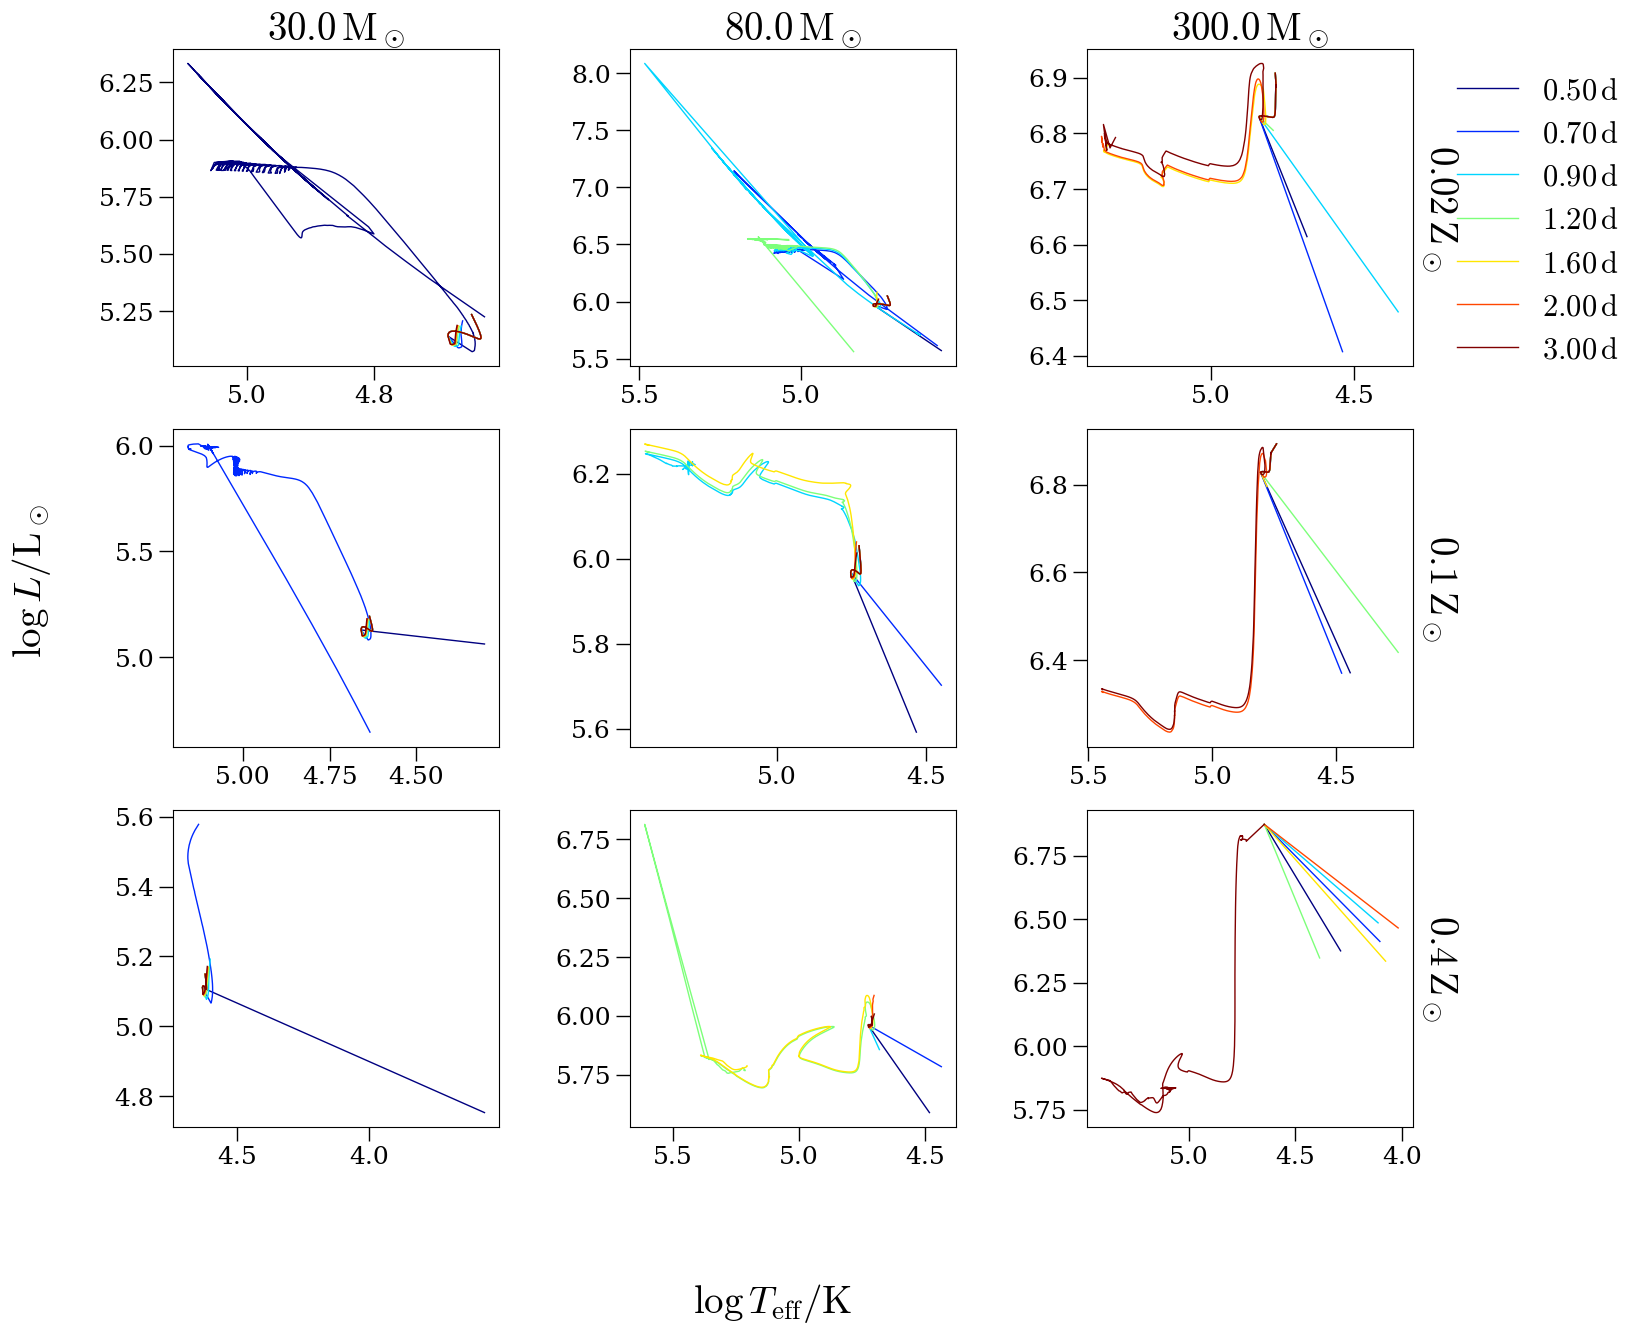

In [ ]:
model_dicts = other_am_model0_dicts

model_dict = model_dicts['0.02']
n_masses = len(model_dict.keys())
n_periods = len(list(model_dict.values())[0].keys())
cmap = cm.jet

n_cols = 3
n_rows = 3
fig_w = 16
fig_h = 14/3 * n_rows
fig, axess = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
fig.subplots_adjust(wspace=0.4)

#############

model_dict = model_dicts['0.02']
axes = axess[0]

m_keys = np.array(list(model_dict.keys()))
m_keys = m_keys[m_keys.astype('float').argsort()]
p_keys = np.array(list(model_dict[m_keys[0]].keys()))
p_keys = p_keys[p_keys.astype('float').argsort()]
for ax, m in zip(axes.ravel(), m_keys):
    m_dict = model_dict[m]
    for i, p in enumerate(p_keys):
        path = m_dict[p]
        h = mr.MesaData(str(path/'LOGS/history.data'))
        x = h.log_Teff
        y = h.log_L
        c = cmap(i/(n_periods-1))
        ax.plot(x, y, c=c, label=f'${p}\\,\\mathrm{{d}}$', lw=1)
        ax.set_title(f'${m}\\,\\mathrm{{M}}_\\odot$')
        
for ax in axes.ravel():
    ax.invert_xaxis()

if axes.ndim == 2:
    ax = axes[0, -1]
else:
    ax = axes[-1]
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.05, 1))

axes[-1].text(1.02, 0.5, '$0.02\\,\\mathrm{Z}_\\odot$', rotation=-90, va='center', ha='left', transform=axes[-1].transAxes)

#############

model_dict = model_dicts['0.1']
axes = axess[1]

m_keys = np.array(list(model_dict.keys()))
m_keys = m_keys[m_keys.astype('float').argsort()]
p_keys = np.array(list(model_dict[m_keys[0]].keys()))
p_keys = p_keys[p_keys.astype('float').argsort()]
for ax, m in zip(axes.ravel(), m_keys):
    m_dict = model_dict[m]
    for i, p in enumerate(p_keys):
        path = m_dict[p]
        h = mr.MesaData(str(path/'LOGS/history.data'))
        x = h.log_Teff
        y = h.log_L
        c = cmap(i/(n_periods-1))
        ax.plot(x, y, c=c, label=f'${p}\\,\\mathrm{{d}}$', lw=1)
        
for ax in axes.ravel():
    ax.invert_xaxis()
    
axes[-1].text(1.02, 0.5, '$0.1\\,\\mathrm{Z}_\\odot$', rotation=-90, va='center', ha='left', transform=axes[-1].transAxes)

#############

model_dict = model_dicts['0.4']
axes = axess[2]

m_keys = np.array(list(model_dict.keys()))
m_keys = m_keys[m_keys.astype('float').argsort()]
p_keys = np.array(list(model_dict[m_keys[0]].keys()))
p_keys = p_keys[p_keys.astype('float').argsort()]
for ax, m in zip(axes.ravel(), m_keys):
    m_dict = model_dict[m]
    for i, p in enumerate(p_keys):
        path = m_dict[p]
        h = mr.MesaData(str(path/'LOGS/history.data'))
        x = h.log_Teff
        y = h.log_L
        c = cmap(i/(n_periods-1))
        ax.plot(x, y, c=c, label=f'${p}\\,\\mathrm{{d}}$', lw=1)
 
for ax in axes.ravel():
    ax.invert_xaxis()
        
axes[-1].text(1.02, 0.5, '$0.4\\,\\mathrm{Z}_\\odot$', rotation=-90, va='center', ha='left', transform=axes[-1].transAxes)
        
###

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')
fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90)


Text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

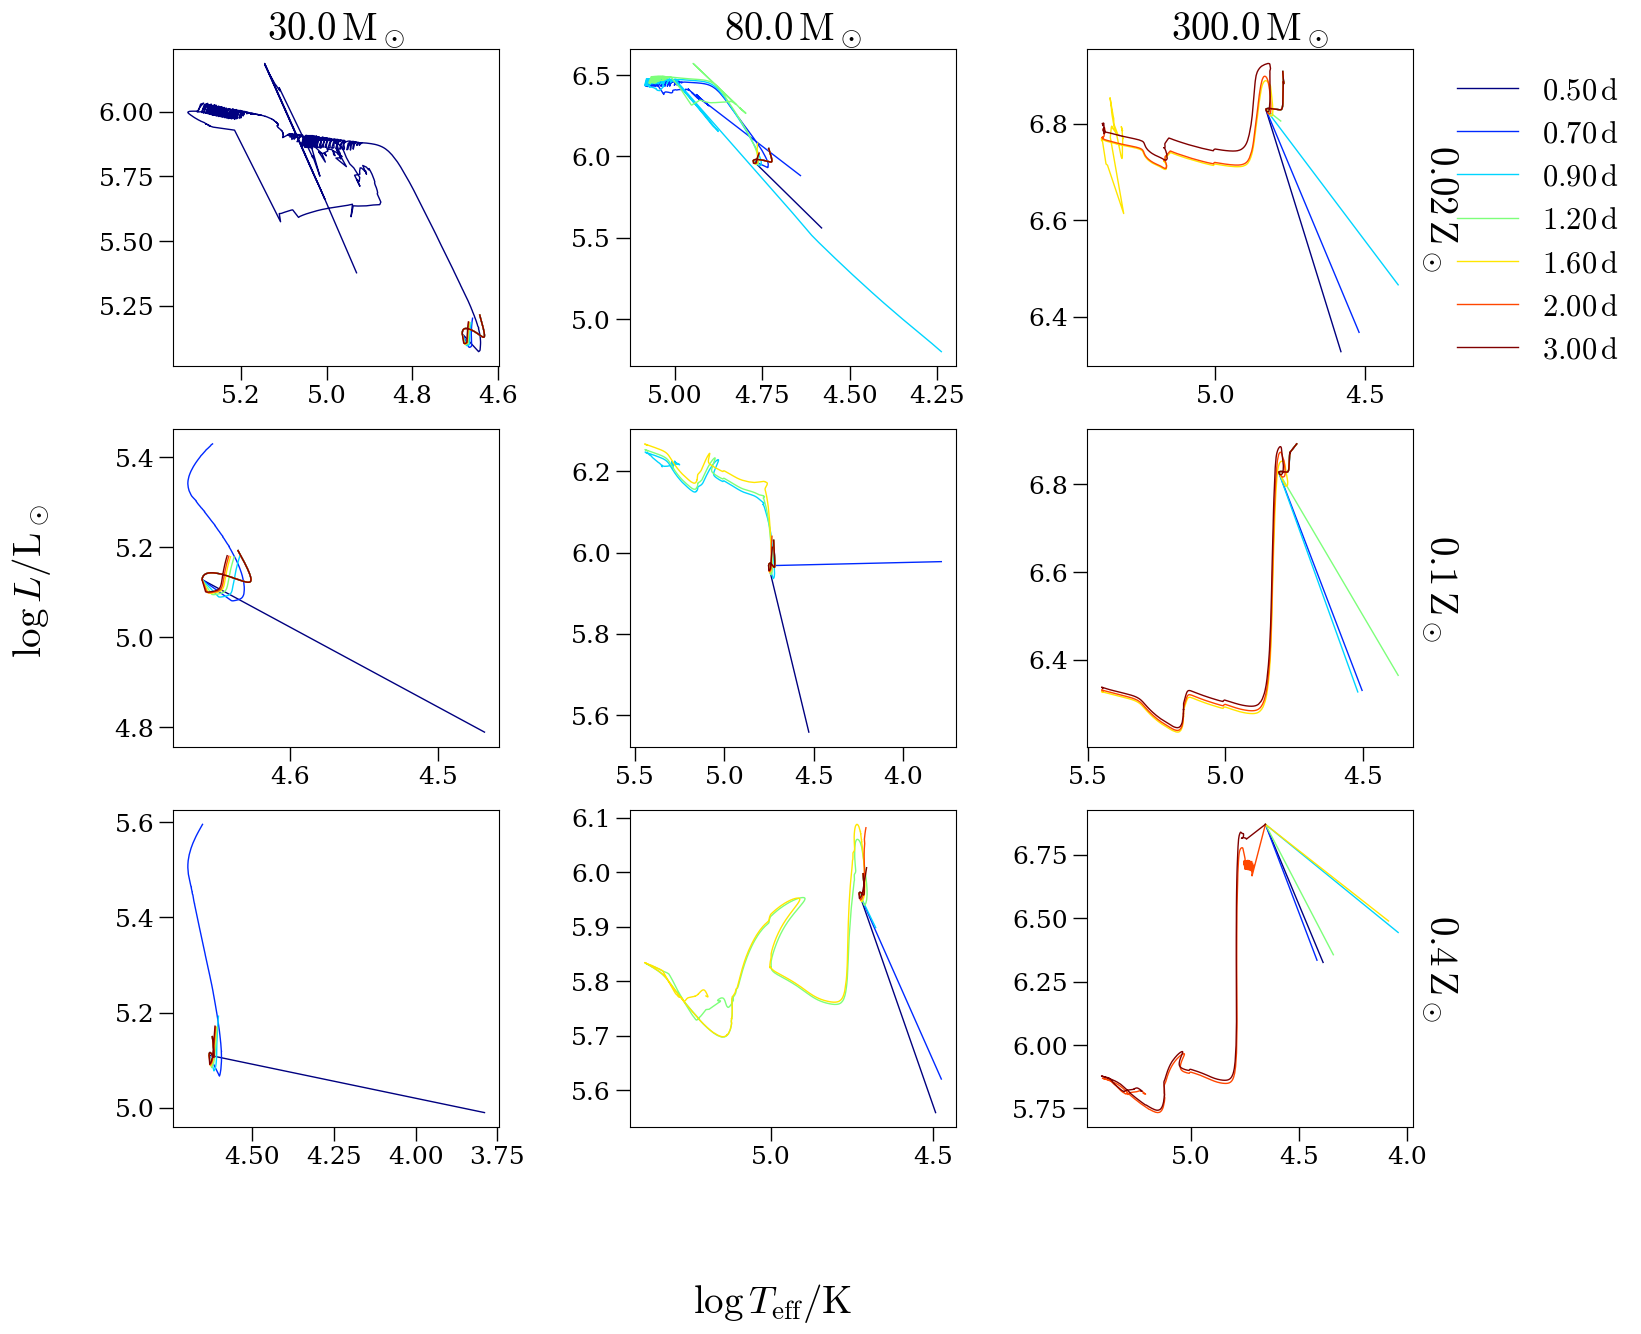

In [ ]:
model_dicts = other_am_model1_dicts

model_dict = model_dicts['0.02']
n_masses = len(model_dict.keys())
n_periods = len(list(model_dict.values())[0].keys())
cmap = cm.jet

n_cols = 3
n_rows = 3
fig_w = 16
fig_h = 14/3 * n_rows
fig, axess = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
fig.subplots_adjust(wspace=0.4)

#############

model_dict = model_dicts['0.02']
axes = axess[0]

m_keys = np.array(list(model_dict.keys()))
m_keys = m_keys[m_keys.astype('float').argsort()]
p_keys = np.array(list(model_dict[m_keys[0]].keys()))
p_keys = p_keys[p_keys.astype('float').argsort()]
for ax, m in zip(axes.ravel(), m_keys):
    m_dict = model_dict[m]
    for i, p in enumerate(p_keys):
        path = m_dict[p]
        h = mr.MesaData(str(path/'LOGS/history.data'))
        x = h.log_Teff
        y = h.log_L
        c = cmap(i/(n_periods-1))
        ax.plot(x, y, c=c, label=f'${p}\\,\\mathrm{{d}}$', lw=1)
        ax.set_title(f'${m}\\,\\mathrm{{M}}_\\odot$')
        
for ax in axes.ravel():
    ax.invert_xaxis()

if axes.ndim == 2:
    ax = axes[0, -1]
else:
    ax = axes[-1]
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.05, 1))

axes[-1].text(1.02, 0.5, '$0.02\\,\\mathrm{Z}_\\odot$', rotation=-90, va='center', ha='left', transform=axes[-1].transAxes)

#############

model_dict = model_dicts['0.1']
axes = axess[1]

m_keys = np.array(list(model_dict.keys()))
m_keys = m_keys[m_keys.astype('float').argsort()]
p_keys = np.array(list(model_dict[m_keys[0]].keys()))
p_keys = p_keys[p_keys.astype('float').argsort()]
for ax, m in zip(axes.ravel(), m_keys):
    m_dict = model_dict[m]
    for i, p in enumerate(p_keys):
        path = m_dict[p]
        h = mr.MesaData(str(path/'LOGS/history.data'))
        x = h.log_Teff
        y = h.log_L
        c = cmap(i/(n_periods-1))
        ax.plot(x, y, c=c, label=f'${p}\\,\\mathrm{{d}}$', lw=1)
        
for ax in axes.ravel():
    ax.invert_xaxis()
    
axes[-1].text(1.02, 0.5, '$0.1\\,\\mathrm{Z}_\\odot$', rotation=-90, va='center', ha='left', transform=axes[-1].transAxes)

#############

model_dict = model_dicts['0.4']
axes = axess[2]

m_keys = np.array(list(model_dict.keys()))
m_keys = m_keys[m_keys.astype('float').argsort()]
p_keys = np.array(list(model_dict[m_keys[0]].keys()))
p_keys = p_keys[p_keys.astype('float').argsort()]
for ax, m in zip(axes.ravel(), m_keys):
    m_dict = model_dict[m]
    for i, p in enumerate(p_keys):
        path = m_dict[p]
        h = mr.MesaData(str(path/'LOGS/history.data'))
        x = h.log_Teff
        y = h.log_L
        c = cmap(i/(n_periods-1))
        ax.plot(x, y, c=c, label=f'${p}\\,\\mathrm{{d}}$', lw=1)
 
for ax in axes.ravel():
    ax.invert_xaxis()
        
axes[-1].text(1.02, 0.5, '$0.4\\,\\mathrm{Z}_\\odot$', rotation=-90, va='center', ha='left', transform=axes[-1].transAxes)
        
###

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')
fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90)


/tmp/ipykernel_992278/689087230.py:21: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
/tmp/ipykernel_992278/689087230.py:41: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)


Text(0, 0.5, '$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

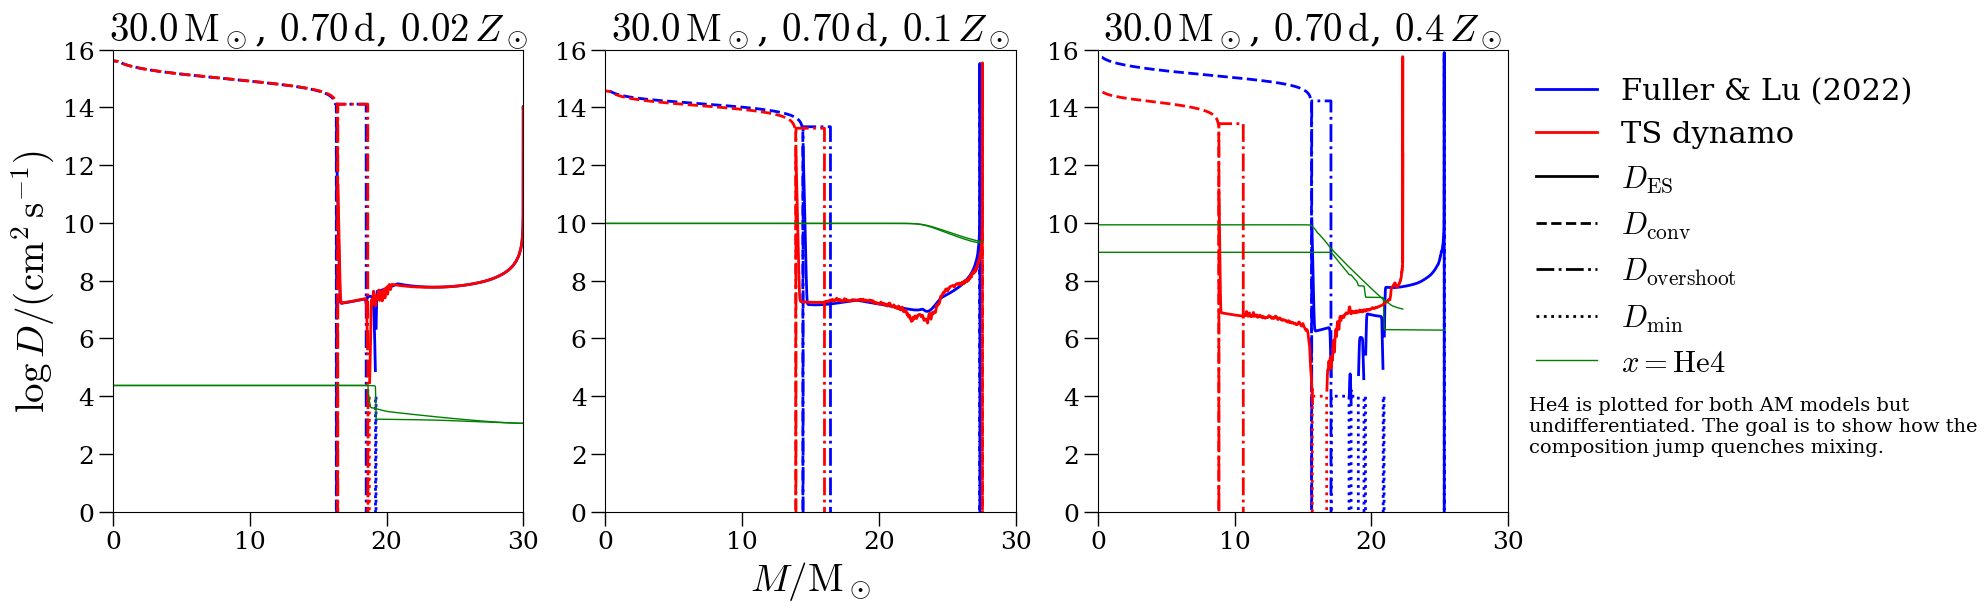

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
model_dicts = other_am_model0_dicts

m_key = '30.0'
p_key = '0.70'
for i, z_key in enumerate(model_dicts.keys()):
    ax = axes[i]
    path = model_dicts[z_key][m_key][p_key]
    c = 'b'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
    
    path = fiducial_model_dicts[z_key][m_key][p_key]
    c = 'r'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
        
    ax.set_title(f'${m_key}\\,\\mathrm{{M}}_\\odot$, ${p_key}\\,\\mathrm{{d}}$, ${z_key}\\,Z_\\odot$')
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 16)

ax = axes[-1]
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='b', ls='-', label='Fuller & Lu (2022)'))
handles.append(Line2D([], [], c='r', ls='-', label='TS dynamo'))
handles.append(Line2D([], [], c='k', ls='-', label='$D_\\mathrm{ES}$'))
handles.append(Line2D([], [], c='k', ls='--', label='$D_\\mathrm{conv}$'))
handles.append(Line2D([], [], c='k', ls='-.', label='$D_\\mathrm{overshoot}$'))
handles.append(Line2D([], [], c='k', ls=':', label='$D_\\mathrm{min}$'))
handles.append(Line2D([], [], c='g', ls='-', lw=1, label='$x=\\mathrm{He4}$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

he4_descr = '\n'.join((
    'He4 is plotted for both AM models but',
    'undifferentiated. The goal is to show how the',
    'composition jump quenches mixing.'
    ))
ax.text(1.05, 0.25, he4_descr, va='top', ha='left', transform=ax.transAxes, fontsize=14)

axes[1].set_xlabel('$M/\\mathrm{M}_\\odot$')
axes[0].set_ylabel('$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

/tmp/ipykernel_992278/4011592842.py:21: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
/tmp/ipykernel_992278/4011592842.py:41: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)


Text(0, 0.5, '$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

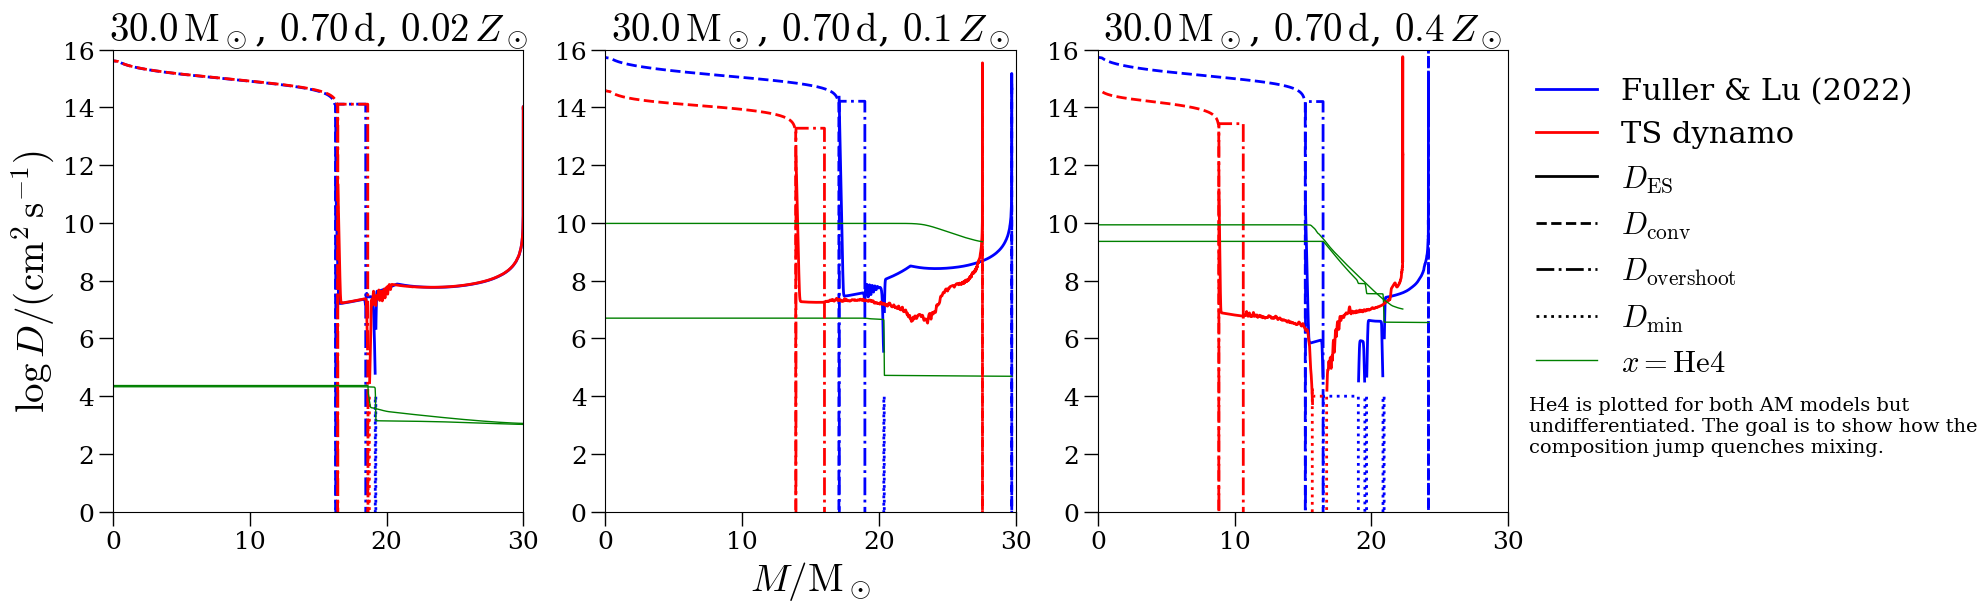

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
model_dicts = other_am_model1_dicts

m_key = '30.0'
p_key = '0.70'
for i, z_key in enumerate(model_dicts.keys()):
    ax = axes[i]
    path = model_dicts[z_key][m_key][p_key]
    c = 'b'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
    
    path = fiducial_model_dicts[z_key][m_key][p_key]
    c = 'r'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
        
    ax.set_title(f'${m_key}\\,\\mathrm{{M}}_\\odot$, ${p_key}\\,\\mathrm{{d}}$, ${z_key}\\,Z_\\odot$')
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 16)

ax = axes[-1]
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='b', ls='-', label='Fuller & Lu (2022)'))
handles.append(Line2D([], [], c='r', ls='-', label='TS dynamo'))
handles.append(Line2D([], [], c='k', ls='-', label='$D_\\mathrm{ES}$'))
handles.append(Line2D([], [], c='k', ls='--', label='$D_\\mathrm{conv}$'))
handles.append(Line2D([], [], c='k', ls='-.', label='$D_\\mathrm{overshoot}$'))
handles.append(Line2D([], [], c='k', ls=':', label='$D_\\mathrm{min}$'))
handles.append(Line2D([], [], c='g', ls='-', lw=1, label='$x=\\mathrm{He4}$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

he4_descr = '\n'.join((
    'He4 is plotted for both AM models but',
    'undifferentiated. The goal is to show how the',
    'composition jump quenches mixing.'
    ))
ax.text(1.05, 0.25, he4_descr, va='top', ha='left', transform=ax.transAxes, fontsize=14)

axes[1].set_xlabel('$M/\\mathrm{M}_\\odot$')
axes[0].set_ylabel('$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

/tmp/ipykernel_992278/1988045393.py:21: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
/tmp/ipykernel_992278/1988045393.py:41: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)


Text(0, 0.5, '$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

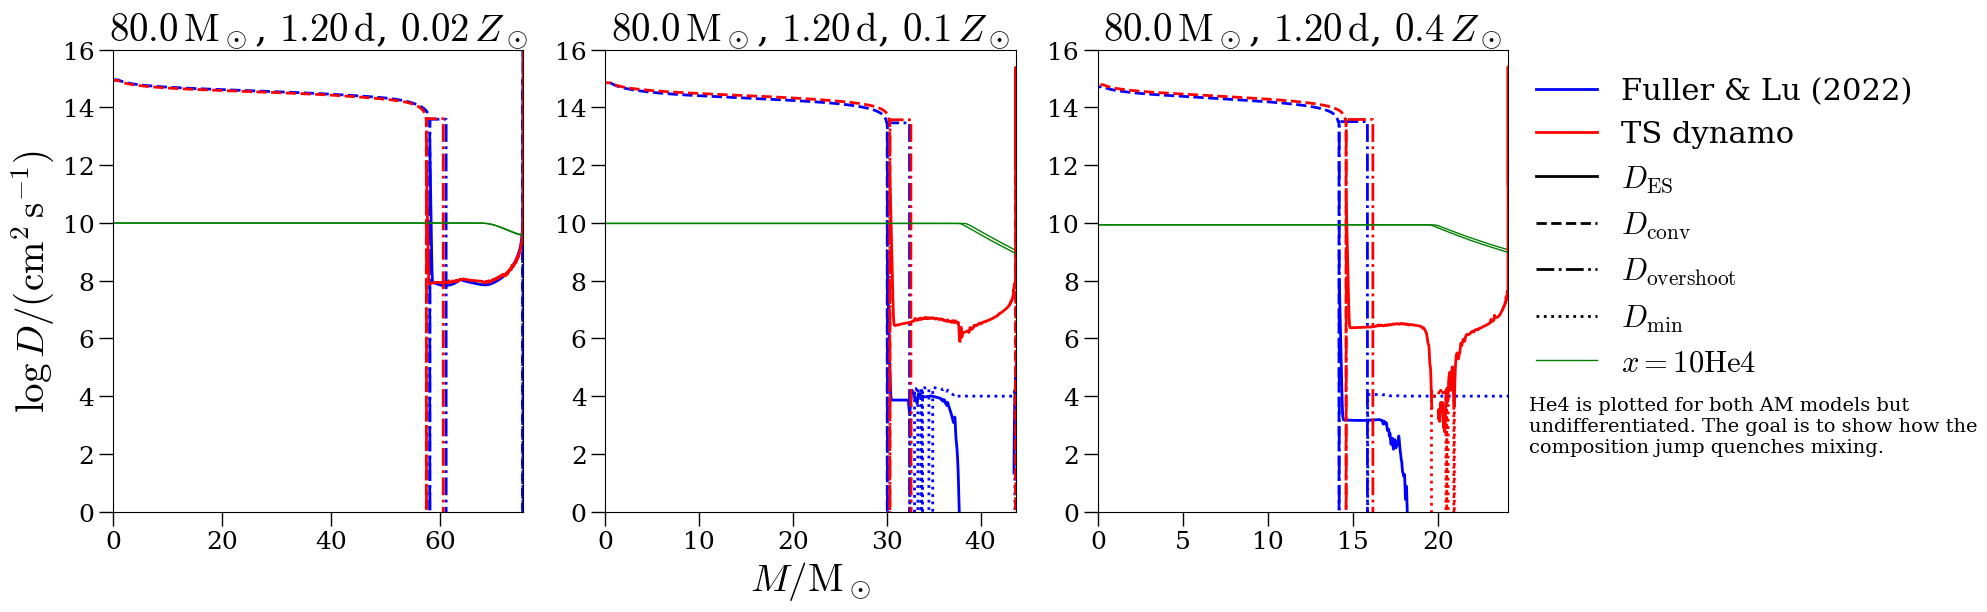

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
model_dicts = other_am_model1_dicts

m_key = '80.0'
p_key = '1.20'
for i, z_key in enumerate(model_dicts.keys()):
    ax = axes[i]
    path = model_dicts[z_key][m_key][p_key]
    c = 'b'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
    
    path = fiducial_model_dicts[z_key][m_key][p_key]
    c = 'r'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
        
    ax.set_title(f'${m_key}\\,\\mathrm{{M}}_\\odot$, ${p_key}\\,\\mathrm{{d}}$, ${z_key}\\,Z_\\odot$')
    ax.set_xlim(0, prof.mass[0])
    ax.set_ylim(0, 16)

ax = axes[-1]
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='b', ls='-', label='Fuller & Lu (2022)'))
handles.append(Line2D([], [], c='r', ls='-', label='TS dynamo'))
handles.append(Line2D([], [], c='k', ls='-', label='$D_\\mathrm{ES}$'))
handles.append(Line2D([], [], c='k', ls='--', label='$D_\\mathrm{conv}$'))
handles.append(Line2D([], [], c='k', ls='-.', label='$D_\\mathrm{overshoot}$'))
handles.append(Line2D([], [], c='k', ls=':', label='$D_\\mathrm{min}$'))
handles.append(Line2D([], [], c='g', ls='-', lw=1, label='$x=10\\mathrm{He4}$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

he4_descr = '\n'.join((
    'He4 is plotted for both AM models but',
    'undifferentiated. The goal is to show how the',
    'composition jump quenches mixing.'
    ))
ax.text(1.05, 0.25, he4_descr, va='top', ha='left', transform=ax.transAxes, fontsize=14)

axes[1].set_xlabel('$M/\\mathrm{M}_\\odot$')
axes[0].set_ylabel('$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

/tmp/ipykernel_1011654/951904848.py:21: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
/tmp/ipykernel_1011654/951904848.py:41: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)


Text(0, 0.5, '$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

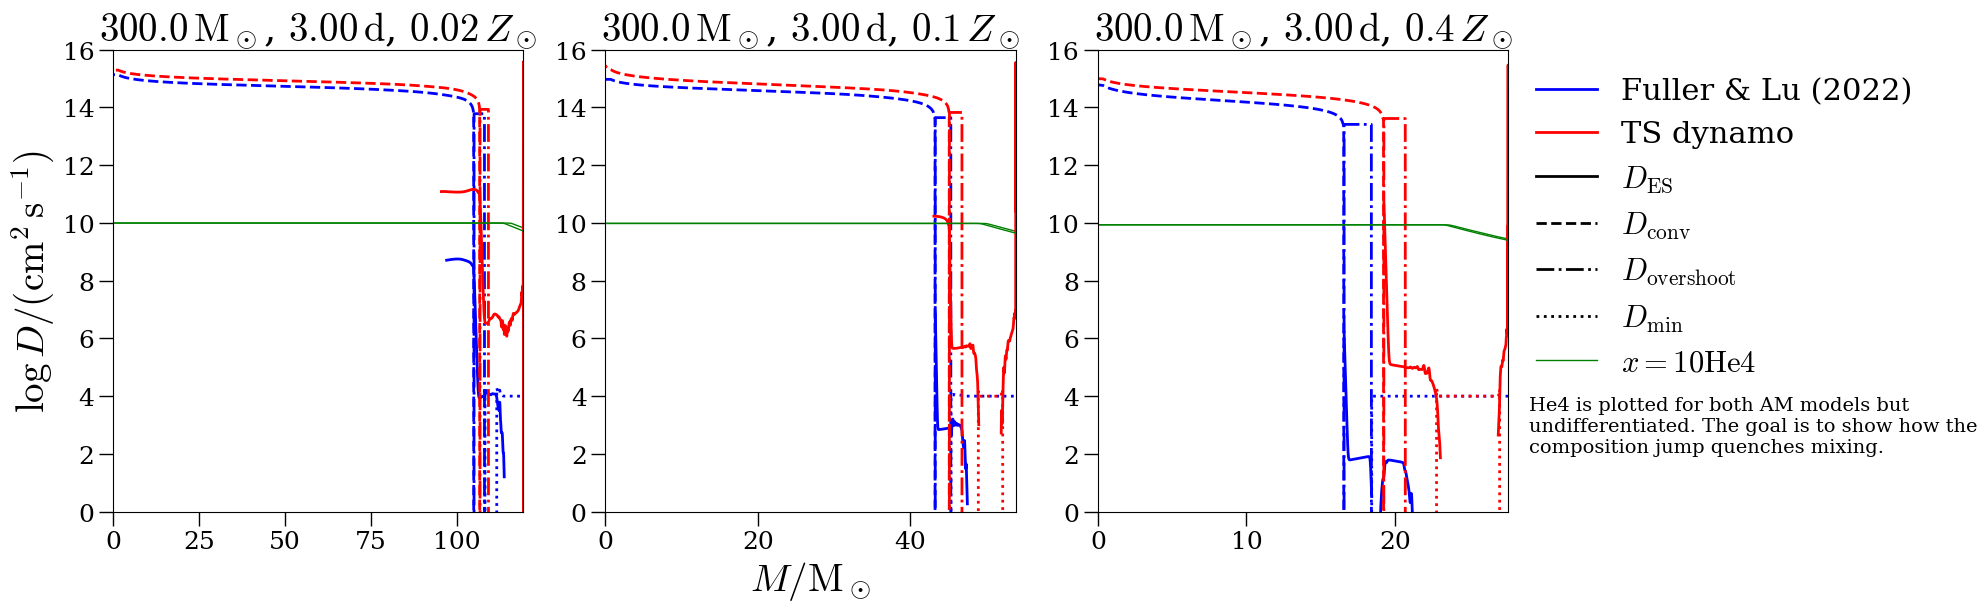

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
model_dicts = other_am_model1_dicts

m_key = '300.0'
p_key = '3.00'
for i, z_key in enumerate(model_dicts.keys()):
    ax = axes[i]
    path = model_dicts[z_key][m_key][p_key]
    c = 'b'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
    
    path = fiducial_model_dicts[z_key][m_key][p_key]
    c = 'r'
    logs = mr.MesaLogDir(str(path/'LOGS'))
    model_n = logs.select_models(
        lambda h1: h1 < 1e-6, 
        'center_h1'
        )
    try:
        prof = logs.profile_data(model_number=model_n[0])
    except IndexError:
        prof = logs.profile_data()
    finally:
        x = prof.mass
        y = np.log10(10.**prof.log_D_mix - 10.**prof.log_D_mix_non_rotation)
        ax.plot(x, y, '-', c=c)
        ax.plot(x, prof.log_D_conv, '--', c=c)
        ax.plot(x, prof.log_D_ovr, '-.', c=c)
        ax.plot(x, prof.log_D_minimum, ':', c=c)
        ax.plot(x, 10*prof.he4, '-', lw=1, c='g')
        
    ax.set_title(f'${m_key}\\,\\mathrm{{M}}_\\odot$, ${p_key}\\,\\mathrm{{d}}$, ${z_key}\\,Z_\\odot$')
    ax.set_xlim(0, prof.mass[0])
    ax.set_ylim(0, 16)

ax = axes[-1]
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([], [], c='b', ls='-', label='Fuller & Lu (2022)'))
handles.append(Line2D([], [], c='r', ls='-', label='TS dynamo'))
handles.append(Line2D([], [], c='k', ls='-', label='$D_\\mathrm{ES}$'))
handles.append(Line2D([], [], c='k', ls='--', label='$D_\\mathrm{conv}$'))
handles.append(Line2D([], [], c='k', ls='-.', label='$D_\\mathrm{overshoot}$'))
handles.append(Line2D([], [], c='k', ls=':', label='$D_\\mathrm{min}$'))
handles.append(Line2D([], [], c='g', ls='-', lw=1, label='$x=10\\mathrm{He4}$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

he4_descr = '\n'.join((
    'He4 is plotted for both AM models but',
    'undifferentiated. The goal is to show how the',
    'composition jump quenches mixing.'
    ))
ax.text(1.05, 0.25, he4_descr, va='top', ha='left', transform=ax.transAxes, fontsize=14)

axes[1].set_xlabel('$M/\\mathrm{M}_\\odot$')
axes[0].set_ylabel('$\\log D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')

In [ ]:
core_props_df_0 = pd.read_hdf(DATA_ROOT/'core_props_df.h5')
core_props_df_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 0 to 1599
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   z_key               1600 non-null   object 
 1   m_zams              1600 non-null   float64
 2   m_wr0               420 non-null    float64
 3   m_wr1               420 non-null    float64
 4   m_tams              420 non-null    float64
 5   m_tahems            420 non-null    float64
 6   m_f                 420 non-null    float64
 7   m_c_zams            420 non-null    float64
 8   m_c_wr0             420 non-null    float64
 9   m_c_wr1             420 non-null    float64
 10  m_c_tams            420 non-null    float64
 11  m_c_tahems          420 non-null    float64
 12  m_c_f               420 non-null    float64
 13  inertia_zams        420 non-null    float64
 14  inertia_wr0         420 non-null    float64
 15  inertia_wr1         420 non-null    float64
 16  inertia_tam

In [ ]:
core_props_df_71 = pd.read_hdf(DATA_ROOT/'7_other_am1_core_props_df.h5')
core_props_df_71.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 0 to 62
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   z_key               63 non-null     object 
 1   m_zams              63 non-null     float64
 2   m_wr0               14 non-null     float64
 3   m_wr1               14 non-null     float64
 4   m_tams              14 non-null     float64
 5   m_tahems            14 non-null     float64
 6   m_f                 14 non-null     float64
 7   m_c_zams            14 non-null     float64
 8   m_c_wr0             14 non-null     float64
 9   m_c_wr1             14 non-null     float64
 10  m_c_tams            14 non-null     float64
 11  m_c_tahems          14 non-null     float64
 12  m_c_f               14 non-null     float64
 13  inertia_zams        14 non-null     float64
 14  inertia_wr0         14 non-null     float64
 15  inertia_wr1         14 non-null     float64
 16  inertia_tams   

In [ ]:
core_props_df_70 = pd.read_hdf(DATA_ROOT/'7_other_am0_core_props_df.h5')
core_props_df_70.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 0 to 62
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   z_key               63 non-null     object 
 1   m_zams              63 non-null     float64
 2   m_wr0               13 non-null     float64
 3   m_wr1               13 non-null     float64
 4   m_tams              13 non-null     float64
 5   m_tahems            13 non-null     float64
 6   m_f                 13 non-null     float64
 7   m_c_zams            13 non-null     float64
 8   m_c_wr0             13 non-null     float64
 9   m_c_wr1             13 non-null     float64
 10  m_c_tams            13 non-null     float64
 11  m_c_tahems          13 non-null     float64
 12  m_c_f               13 non-null     float64
 13  inertia_zams        13 non-null     float64
 14  inertia_wr0         13 non-null     float64
 15  inertia_wr1         13 non-null     float64
 16  inertia_tams   

In [ ]:
core_props_df_0['z'] = core_props_df_0['z_key'].astype('float')
core_props_df_70['z'] = core_props_df_70['z_key'].astype('float')
core_props_df_71['z'] = core_props_df_71['z_key'].astype('float')

In [ ]:
def set_x(row, stage='f'):
    j = 10.**row[f'log_j_{stage}'] * u.g * u.cm**2 / u.s
    m = row[f'm_{stage}'] * u.Msun
    x = ct.c * j / ct.G / m**2
    x = x.to(u.dimensionless_unscaled).value
    return x

stages = ['zams', 'wr0', 'wr1', 'tams', 'tahems', 'f']
for stage in stages:
    core_props_df_0[f'x_{stage}'] = core_props_df_0.apply(lambda row: set_x(row, stage=stage), axis=1)
    core_props_df_70[f'x_{stage}'] = core_props_df_70.apply(lambda row: set_x(row, stage=stage), axis=1)
    core_props_df_71[f'x_{stage}'] = core_props_df_71.apply(lambda row: set_x(row, stage=stage), axis=1)

In [ ]:
np.sort(core_props_df_0.z_key.unique())[[2,4,6]]

array(['0.02', '0.1', '0.4'], dtype=object)

Text(0, 0.5, '$\\chi_\\mathrm{f}$')

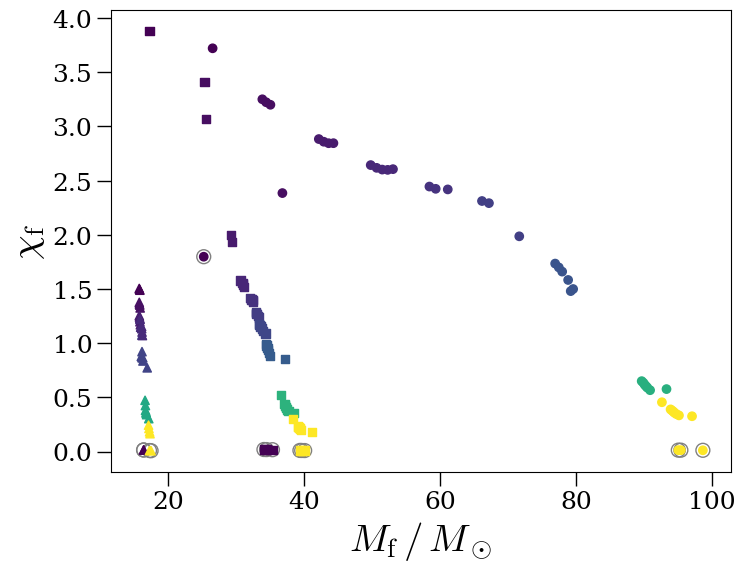

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
def cmap(m):
    return cm.viridis((m-30)/270)

for z_key, marker in zip(sorted(core_props_df_71.z_key.unique()), ['o', 's', '^']):
    subdf = core_props_df_71[core_props_df_71.z_key == z_key]
    ax.scatter(subdf.m_f, subdf.x_f, c=subdf.m_zams, cmap='viridis', marker=marker)
    ax.scatter(subdf.m_f, subdf.x_f, marker='o', facecolor='none', edgecolor='gray', s=100, zorder=0)

for z_key, marker in zip(np.sort(core_props_df_0.z_key.unique())[[2,4,6]], ['o', 's', '^']):
    subdf = core_props_df_0[core_props_df_0.z_key == z_key]
    ax.scatter(subdf.m_f, subdf.x_f, c=subdf.m_zams, cmap='viridis', marker=marker)

#ax.set_ylim(0, 1)
ax.set_xlabel('$M_\\mathrm{f}\\, /\\, M_\\odot$')
ax.set_ylabel('$\chi_\\mathrm{f}$')

/tmp/ipykernel_992278/3822635605.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=cm.viridis(0), marker='o', label='$0.02\\,\\mathrm{Z}_\\odot$'))
/tmp/ipykernel_992278/3822635605.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=cm.viridis(0.5), marker='o', label='$0.1\\,\\mathrm{Z}_\\odot$'))
/tmp/ipykernel_992278/3822635605.py:18: UserWarning: 

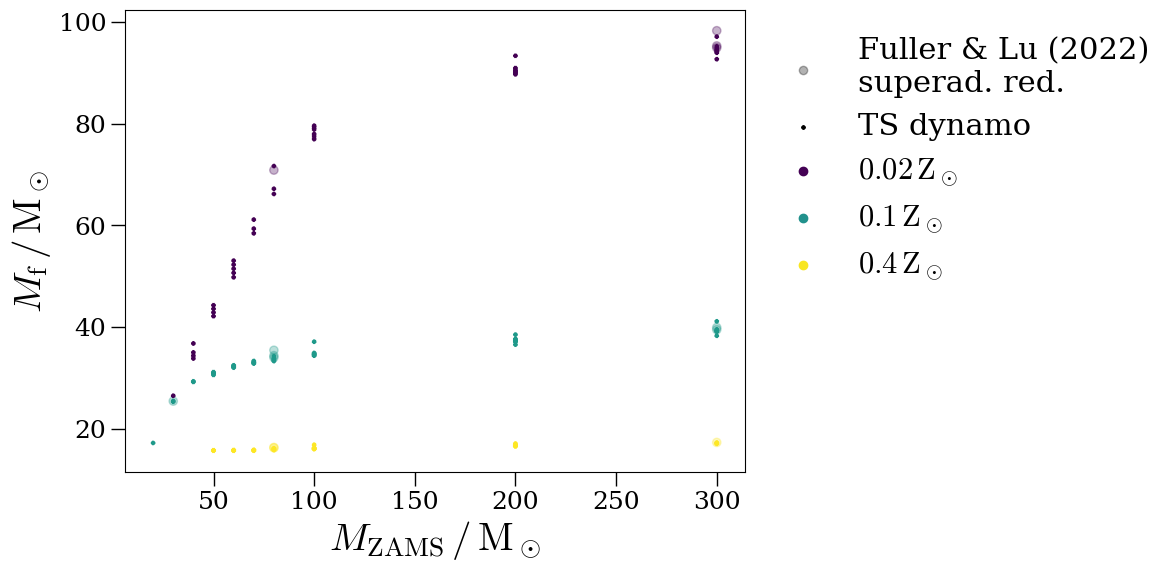

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

subdf0 = core_props_df_0[np.logical_or((core_props_df_0.z_key == '0.02'),
                                       np.logical_or((core_props_df_0.z_key == '0.1'),
                                                     (core_props_df_0.z_key == '0.4')
                                                     ))]

ax.scatter(core_props_df_70.m_zams, core_props_df_70.m_f, c=np.log10(core_props_df_70.z), cmap='viridis', marker='o', alpha=0.3)
ax.scatter(subdf0.m_zams, subdf0.m_f, c=np.log10(subdf0.z), cmap='viridis', marker='x', s=5)
ax.set_xlabel('$M_\\mathrm{ZAMS}\\, /\\, \\mathrm{M}_\\odot$')
ax.set_ylabel('$M_\\mathrm{f}\\, /\\, \\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], c='k', marker='o', label='Fuller & Lu (2022)\nsuperad. red.', alpha=0.3))
handles.append(ax.scatter([], [], c='k', marker='x', label='TS dynamo', s=5))
handles.append(ax.scatter([], [], c=cm.viridis(0), marker='o', label='$0.02\\,\\mathrm{Z}_\\odot$'))
handles.append(ax.scatter([], [], c=cm.viridis(0.5), marker='o', label='$0.1\\,\\mathrm{Z}_\\odot$'))
handles.append(ax.scatter([], [], c=cm.viridis(0.99), marker='o', label='$0.4\\,\\mathrm{Z}_\\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

/tmp/ipykernel_992278/3164740338.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=cm.viridis(0), marker='o', label='$0.02\\,\\mathrm{Z}_\\odot$'))
/tmp/ipykernel_992278/3164740338.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=cm.viridis(0.5), marker='o', label='$0.1\\,\\mathrm{Z}_\\odot$'))
/tmp/ipykernel_992278/3164740338.py:18: UserWarning: 

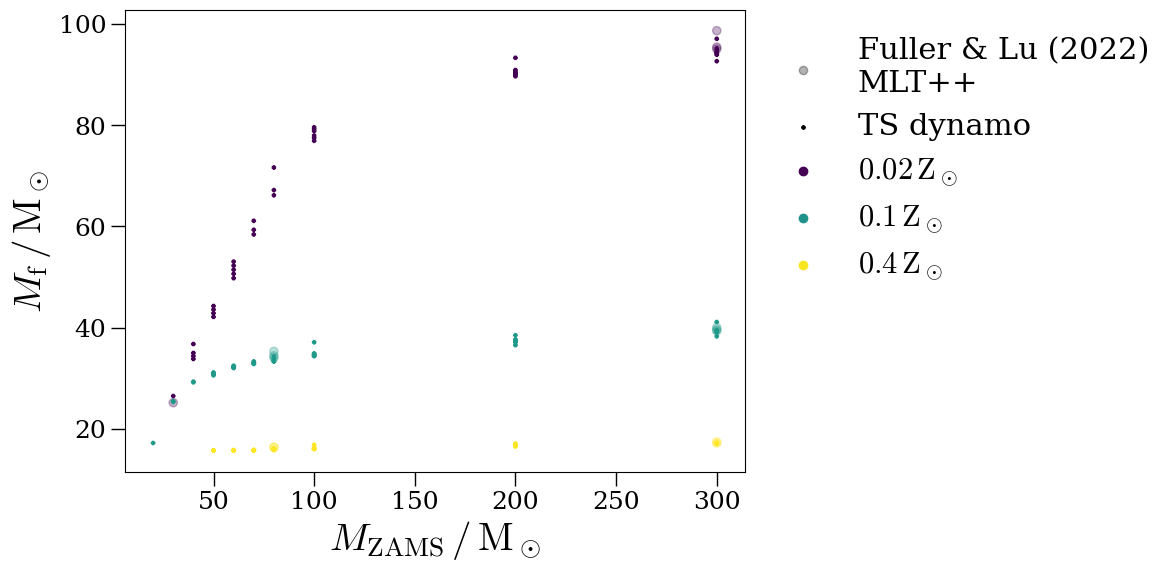

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

subdf0 = core_props_df_0[np.logical_or((core_props_df_0.z_key == '0.02'),
                                       np.logical_or((core_props_df_0.z_key == '0.1'),
                                                     (core_props_df_0.z_key == '0.4')
                                                     ))]

ax.scatter(core_props_df_71.m_zams, core_props_df_71.m_f, c=np.log10(core_props_df_71.z), cmap='viridis', marker='o', alpha=0.3)
ax.scatter(subdf0.m_zams, subdf0.m_f, c=np.log10(subdf0.z), cmap='viridis', marker='x', s=5)
ax.set_xlabel('$M_\\mathrm{ZAMS}\\, /\\, \\mathrm{M}_\\odot$')
ax.set_ylabel('$M_\\mathrm{f}\\, /\\, \\mathrm{M}_\\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], c='k', marker='o', label='Fuller & Lu (2022)\nMLT++', alpha=0.3))
handles.append(ax.scatter([], [], c='k', marker='x', label='TS dynamo', s=5))
handles.append(ax.scatter([], [], c=cm.viridis(0), marker='o', label='$0.02\\,\\mathrm{Z}_\\odot$'))
handles.append(ax.scatter([], [], c=cm.viridis(0.5), marker='o', label='$0.1\\,\\mathrm{Z}_\\odot$'))
handles.append(ax.scatter([], [], c=cm.viridis(0.99), marker='o', label='$0.4\\,\\mathrm{Z}_\\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

#### Evolution up to core-collapse

Let us look at our one succesful run up to core-collapse.

In [ ]:
import mesaPlot as mp

In [ ]:
model_dicts = other_am_model1_dicts
z_key = '0.1'
m_key = '80.0'
p_key = '0.90'
path = model_dicts[z_key][m_key][p_key]
h = mr.MesaData(str(path/'LOGS/history.data'))
logs = mr.MesaLogDir(str(path/'LOGS'))

In [ ]:
import astropy.units as u

In [ ]:
prof = mr.MesaData(str(path/'LOGS/CHE_single_core_collapse.data'))
Cprof = mr.MesaData(str(path/'LOGS/C_depl.data'))

In [ ]:
def r_isco(m, a):
    """Radius at ISCO (prograde) for a Kerr BH with mass m and spin a."""
    m = m * ct.M_sun.cgs * ct.G.cgs / ct.c.cgs**2
    z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    z2 = (3 * a**2 + z1**2)**(1/2)
    r = m * (3 + z2 - ((3 - z1) * (3 + z1 + 2 * z2))**(1/2))
    return r

def j_isco(m, a):
    """Angular momentum at ISCO (prograde) for a Kerr BH with mass m and spin a."""
    r = r_isco(m, a)
    m = m * ct.M_sun.cgs * ct.G.cgs / ct.c.cgs**2
    a = a * m
    j = (
        m**(1/2) / r**(3/4)
        * (
            r**2
            - 2 * a * m**(1/2) * r**(1/2)
            + a**2
        )
        / (
            r**(3/2)
            - 3 * m * r**(1/2)
            + 2 * a * m**(1/2)
        )**(1/2)
        
    )
    return j

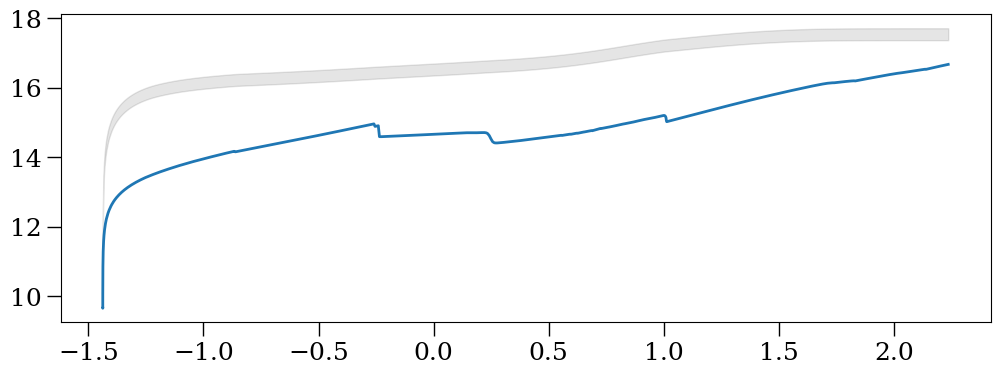

In [ ]:
fig, ax  =  plt.subplots(figsize=(12, 4))

r = prof.radius * u.Rsun.to(u.cm)
m = prof.mass * u.Msun.to(u.g)
x = np.log10(np.sqrt(
    3 * np.pi * r**3 / (32 * ct.G.cgs.value * m)
)) # free-fall time
y = prof.log_j_rot
ax.plot(x, y)

j = 10.**y * u.cm**2 / u.s * u.g
a = ct.c.cgs * j / (ct.G.cgs * m**2 * u.g**2)
a = a.to(u.dimensionless_unscaled).value
y = np.log10(j_isco(m, a).value * ct.c.cgs.value)
ax.plot()

m = prof.mass
min_j_isco = j_isco(m, 0)
max_j_isco = j_isco(m, 0.99)
y0 = np.log10((min_j_isco * ct.c.cgs).value)
y1 = np.log10((max_j_isco * ct.c.cgs).value)
#ax.plot(x, y0, 'k-', lw=1)
#ax.plot(x, y1, 'k-', lw=1)
ax.fill_between(x, y0, y1, color='k', alpha=0.1, label='ISCO range')

In [ ]:
model_dicts = fiducial_model_dicts
z_key = '0.1'
m_key = '80.0'
p_key = '0.90'
path = model_dicts[z_key][m_key][p_key]
h = mr.MesaData(str(path/'LOGS/history.data'))
logs = mr.MesaLogDir(str(path/'LOGS'))

In [ ]:
import astropy.units as u

In [ ]:
prof = mr.MesaData(str(path/'LOGS/CHE_single_core_collapse.data'))

In [ ]:
def r_isco(m, a):
    """Radius at ISCO (prograde) for a Kerr BH with mass m and spin a."""
    m = m * ct.M_sun.cgs * ct.G.cgs / ct.c.cgs**2
    z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    z2 = (3 * a**2 + z1**2)**(1/2)
    r = m * (3 + z2 - ((3 - z1) * (3 + z1 + 2 * z2))**(1/2))
    return r

def j_isco(m, a):
    """Angular momentum at ISCO (prograde) for a Kerr BH with mass m and spin a."""
    r = r_isco(m, a)
    m = m * ct.M_sun.cgs * ct.G.cgs / ct.c.cgs**2
    a = a * m
    j = (
        m**(1/2) / r**(3/4)
        * (
            r**2
            - 2 * a * m**(1/2) * r**(1/2)
            + a**2
        )
        / (
            r**(3/2)
            - 3 * m * r**(1/2)
            + 2 * a * m**(1/2)
        )**(1/2)
        
    )
    return j

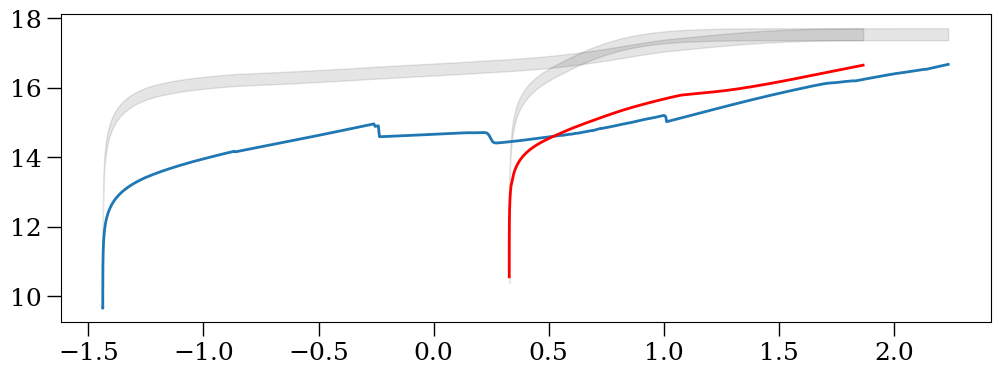

In [ ]:
fig, ax  =  plt.subplots(figsize=(12, 4))

r = prof.radius * u.Rsun.to(u.cm)
m = prof.mass * u.Msun.to(u.g)
x = np.log10(np.sqrt(
    3 * np.pi * r**3 / (32 * ct.G.cgs.value * m)
)) # free-fall time
y = prof.log_j_rot
ax.plot(x, y)

j = 10.**y * u.cm**2 / u.s * u.g
a = ct.c.cgs * j / (ct.G.cgs * m**2 * u.g**2)
a = a.to(u.dimensionless_unscaled).value
y = np.log10(j_isco(m, a).value * ct.c.cgs.value)
ax.plot()

m = prof.mass
min_j_isco = j_isco(m, 0)
max_j_isco = j_isco(m, 0.99)

y0 = np.log10((min_j_isco * ct.c.cgs).value)
y1 = np.log10((max_j_isco * ct.c.cgs).value)
#ax.plot(x, y0, 'k-', lw=1)
#ax.plot(x, y1, 'k-', lw=1)
ax.fill_between(x, y0, y1, color='k', alpha=0.1, label='ISCO range')

r = Cprof.radius * u.Rsun.to(u.cm)
m = Cprof.mass * u.Msun.to(u.g)
x = np.log10(np.sqrt(
    3 * np.pi * r**3 / (32 * ct.G.cgs.value * m)
)) # free-fall time
y = Cprof.log_j_rot
ax.plot(x, y, 'r-')

j = 10.**y * u.cm**2 / u.s * u.g
a = ct.c.cgs * j / (ct.G.cgs * m**2 * u.g**2)
a = a.to(u.dimensionless_unscaled).value
y = np.log10(j_isco(m, a).value * ct.c.cgs.value)
ax.plot()

m = Cprof.mass
min_j_isco = j_isco(m, 0)
max_j_isco = j_isco(m, 0.99)

y0 = np.log10((min_j_isco * ct.c.cgs).value)
y1 = np.log10((max_j_isco * ct.c.cgs).value)
#ax.plot(x, y0, 'k-', lw=1)
#ax.plot(x, y1, 'k-', lw=1)
ax.fill_between(x, y0, y1, color='k', alpha=0.1, label='ISCO range')

In [ ]:
fig, ax  =  plt.subplots(figsize=(12, 4))

r = prof.radius * u.Rsun.to(u.cm)
m = prof.mass * u.Msun.to(u.g)
x = np.log10(np.sqrt(
    3 * np.pi * r**3 / (32 * ct.G.cgs.value * m)
)) # free-fall time
y = prof.log_j_rot
ax.plot(x, y)

j = 10.**y * u.cm**2 / u.s
a = ct.c.cgs * j / (ct.G.cgs * m**2)
a = a.to(u.dimensionless_unscaled).value
y = np.log10(j_isco(m, a) * ct.c.cgs).value)
ax.plot()

m = prof.mass
min_j_isco = j_isco(m, 0)
max_j_isco = j_isco(m, 0.99)
y0 = np.log10((min_j_isco * ct.c.cgs).value)
y1 = np.log10((max_j_isco * ct.c.cgs).value)
#ax.plot(x, y0, 'k-', lw=1)
#ax.plot(x, y1, 'k-', lw=1)
ax.fill_between(x, y0, y1, color='k', alpha=0.1, label='ISCO range')

SyntaxError: unmatched ')' (2357456701.py, line 14)

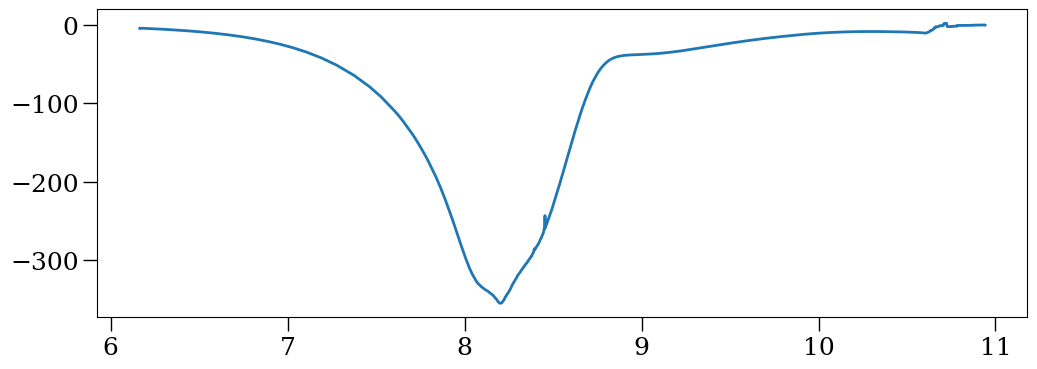

In [ ]:
fig, ax  =  plt.subplots(figsize=(12, 4))
x = np.log10(prof.radius * u.Rsun.to(u.cm))
y = prof.v_div_cs * prof.csound *  (u.cm/u.s).to(u.km/u.s)
ax.plot(x, y)

# Tidal spin-down

In [ ]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m * a
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e3:.2f} kyr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q, t1

In [ ]:
def radiative_damping_torque(total_m, total_r, core_m, core_r, core_bound_rho, p_spin, p_orb, q=1, beta2=1.):
    total_m = fix_unit(total_m, MASS_U)
    total_r = fix_unit(total_r, RADIUS_U)
    core_m = fix_unit(core_m, MASS_U)
    core_r = fix_unit(core_r, RADIUS_U)
    core_bound_rho = fix_unit(core_bound_rho, DENSITY_U)
    p_spin = fix_unit(p_spin, PERIOD_U)
    p_orb = fix_unit(p_orb, PERIOD_U)
    
    w_spin = 2*np.pi/p_spin
    w_orb = 2*np.pi/p_orb
    a = a_from_p(p_orb, total_m, 1)
    d = 2*a
    sc = 2 * np.abs(w_spin - w_orb) * np.sqrt(core_r**3 / ct.G / core_m)
    
    mean_rho_b = (core_m / (4/3 * np.pi * core_r**3)).to(DENSITY_U)
    rho_ratio = core_bound_rho / mean_rho_b
    mass_term = ct.G * (q*total_m)**2 / core_r
    
    torque = beta2 * mass_term * (core_r/d)**6 * sc**(8/3) * rho_ratio * (1 - rho_ratio)**2
    sign = np.sign(w_orb - w_spin)
    return sign * torque.to(TORQUE_U)
    

In [ ]:
def get_moment_of_inertia(prof, stop_i=-1):
    r_arr = prof.radius[::-1] * u.Rsun.to(u.cm)
    rho_arr = 10.**prof.logRho[::-1]
    
    r_arr = r_arr[:stop_i]
    rho_arr = rho_arr[:stop_i]
    
    i = 0
    for rho, r0, r1 in zip(rho_arr, r_arr[:-1], r_arr[1:]):
        dv = 4/3 * np.pi * (r1**3 - r0**3)
        di = rho * r0**2 * dv
        i += di
        
    return i

In [ ]:
path = model_dicts_01zsun['80.0']['1.40']
logs = mr.MesaLogDir(str(path/'LOGS'))

In [ ]:
sync_tscale_evolution = np.zeros((len(logs.model_numbers), 8))
# age center_h1 center_he4 center_c12 p_orb p_spin torque tscale

for i, n in enumerate(logs.model_numbers):
    prof = logs.profile_data(model_number=n)
    conv_core_bound_i = len(prof.mixing_type) - np.where(prof.mixing_type[::-1] != 1)[0][0]
    conv_core_bound_i = min(conv_core_bound_i, len(prof.mixing_type)-1)
    conv_core_bound_rho = 10.**prof.logRho[conv_core_bound_i] * u.g * u.cm**-3
    conv_core_m = prof.mass[conv_core_bound_i] * u.Msun
    conv_core_r = prof.radius[conv_core_bound_i] * u.Rsun
    total_m = prof.mass[0] * u.Msun
    total_r = prof.radius[0] * u.Rsun
    w_spin = prof.omega[0] / u.s
    p_spin = 2*np.pi / w_spin
    total_moment_of_inertia = get_moment_of_inertia(prof) * u.g * u.cm**2

    wi = WindIntegrator(path)
    _m, p_orb, *_ = wi.integrate(prof.star_age)
    p_orb *= u.d.to(u.s) * u.s

    torque = radiative_damping_torque(total_m, total_r, conv_core_m, conv_core_r, conv_core_bound_rho, p_spin, p_orb)

    sync_timescale = np.abs(1/(torque/total_moment_of_inertia / w_spin)).to(u.yr).value
    
    sync_tscale_evolution[i] = [
        prof.star_age,
        prof.h1[-1],
        prof.he4[-1],
        prof.c12[-1],
        p_orb.value,
        p_spin.value,
        torque.value,
        sync_timescale
    ]
        

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, '$P_\\mathrm{spin}/\\mathrm{d}$')

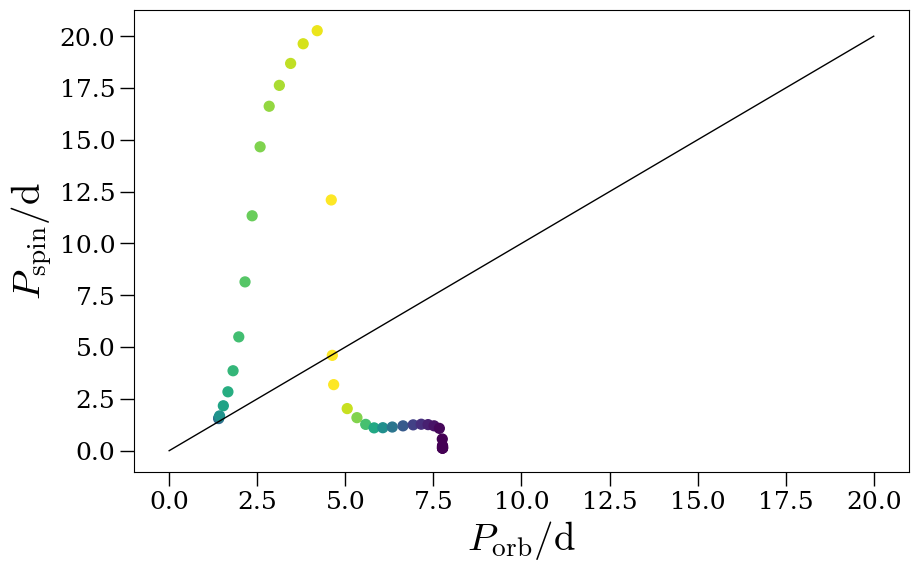

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = cm.viridis

x = sync_tscale_evolution[:, 4] / u.d.to(u.s)
y = sync_tscale_evolution[:, 5] / u.d.to(u.s)
c = sync_tscale_evolution[:, 2]

ax.scatter(x, y, c=c, cmap=cmap, s=50)
ax.plot(np.linspace(0, 20, 10), np.linspace(0, 20, 10), 'k-', lw=1)
#ax.set_xlim(0, 20)
ax.set_xlabel('$P_\\mathrm{orb}/\\mathrm{d}$')
ax.set_ylabel('$P_\\mathrm{spin}/\\mathrm{d}$')
#ax.set_ylim(0, 20)
#ax.set_yscale('log')
#ax.set_ylim(1e-3, 1e6)

(0.001, 1000000000000.0)

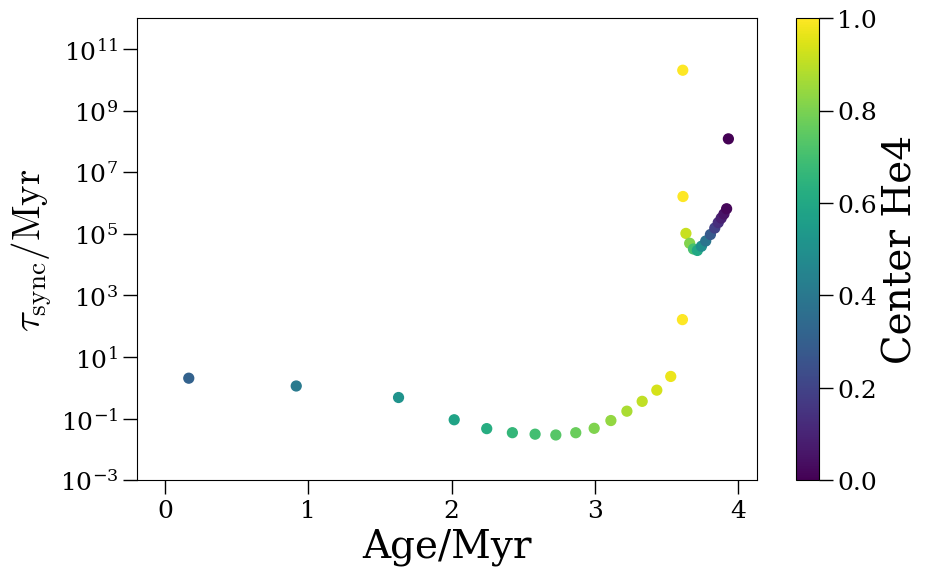

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = cm.viridis

x = sync_tscale_evolution[:, 0] / 1e6
y = sync_tscale_evolution[:, 7] / 1e6
c = sync_tscale_evolution[:, 2]

ax.scatter(x, y, c=c, cmap=cmap, s=50)
ax.set_yscale('log')
#ax.set_ylim(1e-3, 1e6)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\tau_\mathrm{sync}/\\mathrm{Myr}$')

sm = cm.ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('Center He4')
ax.set_ylim(1e-3, 1e12)

In [ ]:
p_orb, p_spin

(<Quantity 18142677.8390437 s>, <Quantity 127012.57781125 s>)

In [ ]:
total_moment_of_inertia * w_spin

<Quantity 2.94732148e+50 cm2 g / s>

In [ ]:
torque = radiative_damping_torque(total_m, total_r, conv_core_m, conv_core_r, conv_core_bound_rho, p_spin, p_orb)

In [ ]:
torque

<Quantity -1.84579961e-12 cm2 g / s2>

In [ ]:
np.abs(1/(torque/total_moment_of_inertia / w_spin)).to(u.Myr)

<Quantity 5.05986573e+48 Myr>

In [ ]:
prof.omega

array([4.94690008e-05, 4.94690008e-05, 4.94691358e-05, ...,
       3.85730004e-03, 3.85730004e-03, 3.85730004e-03])

In [ ]:
prof.mixing_type

array([1, 1, 1, ..., 7, 7, 7])